# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Preparation of Pipline
### Import Libraries & Define utility functions & Set global const values

In [114]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
def show_images(images, titles, num_col, num_row, figsize, fontsize=50):
    """
    Show images in table format.
    """
    title_flg = False
    if len(images) == len(titles):
        title_flg = True
    
    fig = plt.figure(figsize=figsize)
    cur_place = 1
    for idx, img in enumerate(images):
        cur_subplot = fig.add_subplot(num_row, num_col, cur_place)
        
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        
        if title_flg:
            cur_subplot.set_title(titles[idx], fontsize=fontsize)
        
        cur_place += 1
    fig.tight_layout()
    plt.show()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [137]:
# Lane sample image
lane_sample_img = cv2.imread('../test_images/straight_lines1.jpg')
lane_sample_img = cv2.cvtColor(lane_sample_img, cv2.COLOR_BGR2RGB)

### Camera Calibration

In [130]:
def get_calibrated_points(images, objp, nx, ny):
    """
    Get matched points in real world and image space from chessborad images.
    """
    # Results
    obj_points = [] # 3d points in real world
    img_points = [] # 2d points in image 
    result_images = []
    
    for img in images:
        # Covert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            obj_points.append(objp)
            img_points.append(corners)

            # Draw the corners
            result_img = np.copy(img)
            result_images.append(cv2.drawChessboardCorners(result_img, (nx, ny), corners, ret))
            
    return (img_points, obj_points, result_images)

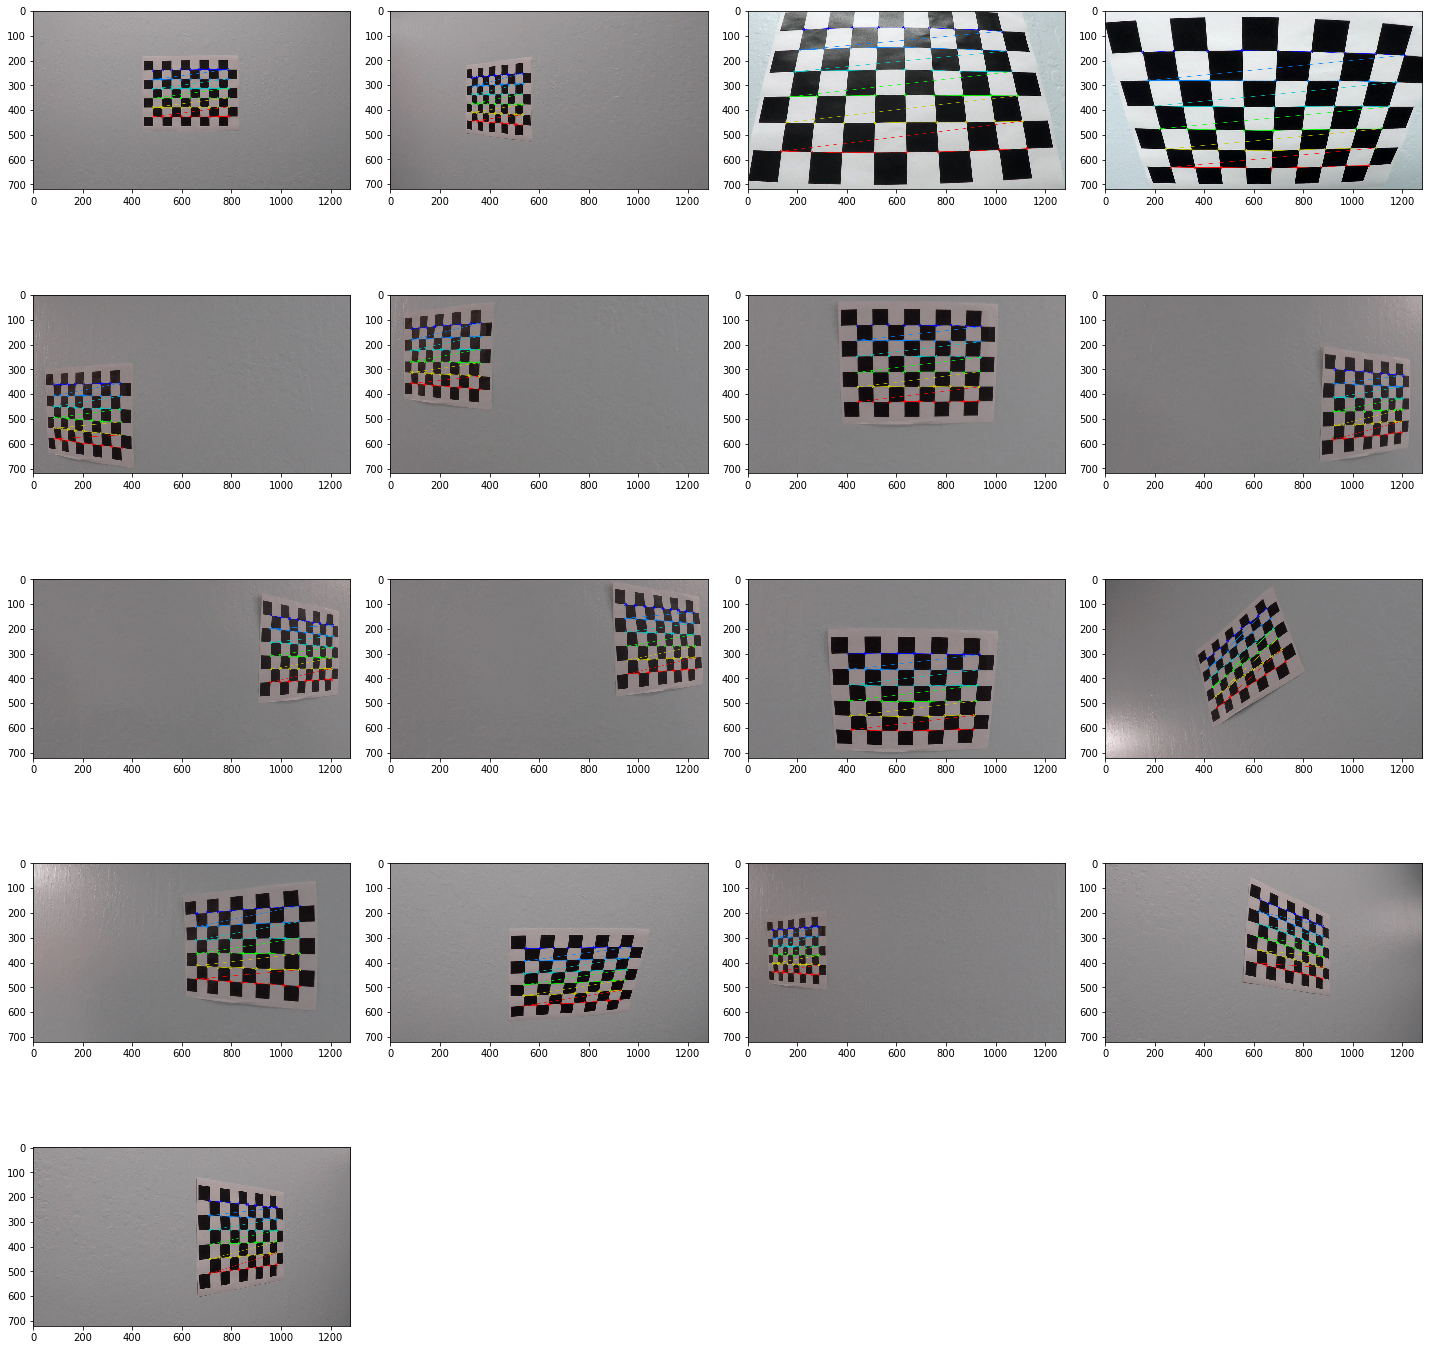

In [131]:
# Load chessboard images
chessboard_images_fnames = glob.glob('../camera_cal/calibration*.jpg')
chessboard_images = []
for fname in chessboard_images_fnames:
    chessboard_images.append(cv2.imread(fname))

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
num_corner_x = 9
num_corner_y = 6
objp = np.zeros((num_corner_y * num_corner_x, 3), np.float32)
objp[:, :2] = np.mgrid[0:num_corner_x, 0:num_corner_y].T.reshape(-1, 2)

# Calibration
img_points, obj_points, result_images = get_calibrated_points(chessboard_images, objp, num_corner_x, num_corner_y)

# Draw corners in calibration images
show_images(result_images, [], 4, int(len(result_images) / 4) + 1, (20, 20))

### Undistortion

In [132]:
def undistort(img, obj_points, img_points):
    """
    Undistort from combination of real world points and image plane points in calibration step.
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, 
                                                       (img.shape[0], img.shape[1]), None, None)
    return cv2.undistort(img, mtx, dist, None, mtx), mtx, dist

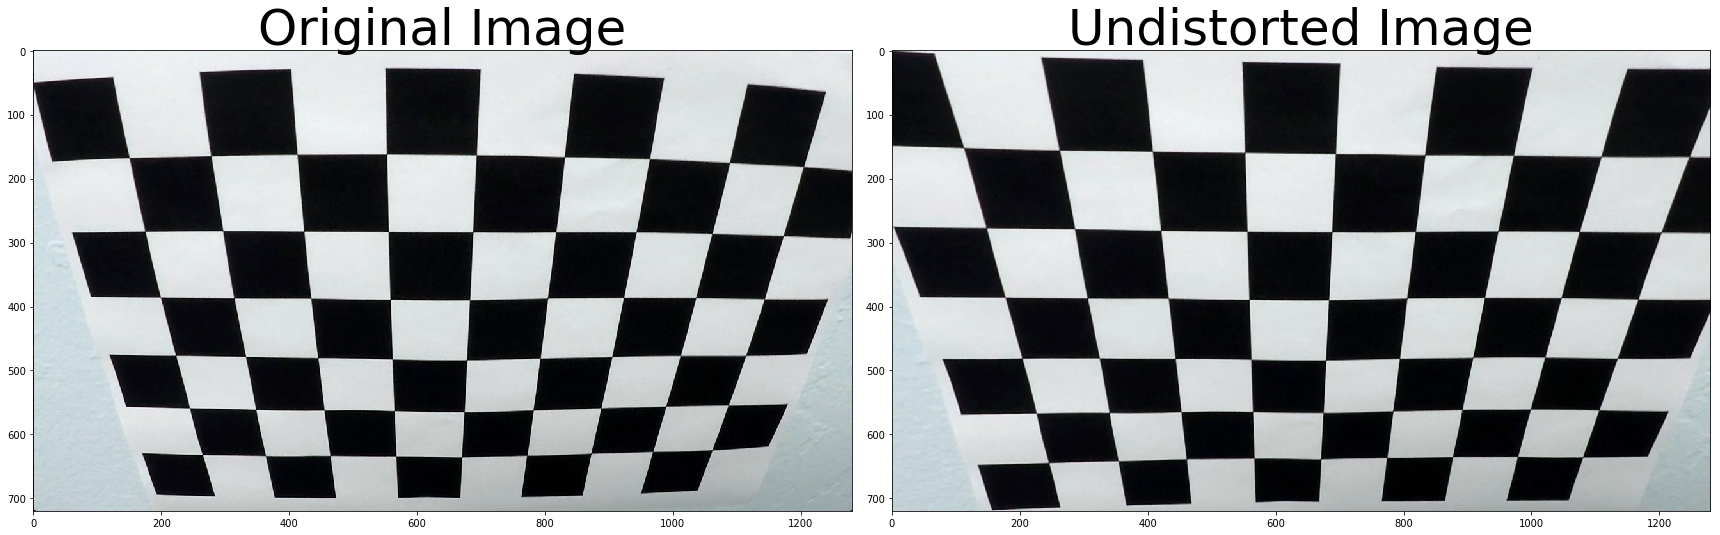

In [218]:
# Pickup a sample distorted image
undist_target_img = chessboard_images[5]

# Undistort
(undist_img, mtx, dist) = undistort(undist_target_img, obj_points, img_points)

# Show result
show_images([undist_target_img, undistorted_img],
            ['Original Image', 'Undistorted Image'],
           2, 1, (24, 9))

### Binarizing by Color and Gradients
color transforms, gradients, etc., to create a thresholded binary image.

In [204]:
def binarize(img, sx_thresh=(20, 100), h_thresh=(42, 80), s_thresh=(80, 255)):
    """
    Select pixels which have expected saturation.
    """
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold with hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold with saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((sx_binary, s_binary, h_binary))
    
    # Combine the three binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (h_binary == 1) | (s_binary == 1)] = 1
    
    return (combined_binary, color_binary)

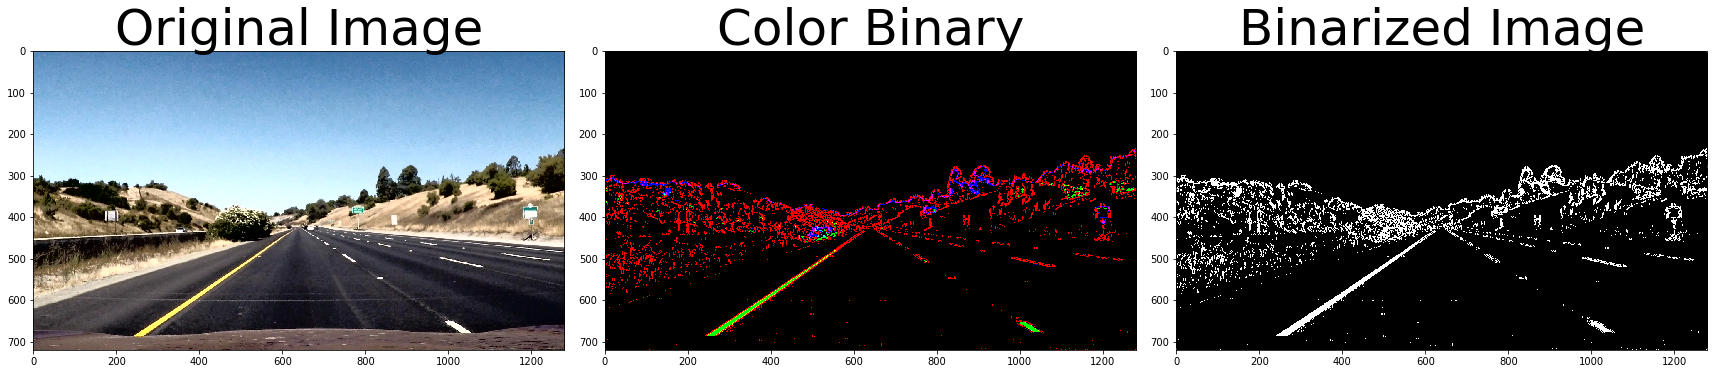

In [203]:
# Binarizing
binarized_img, threshold_result_img = binarize(smoothed_img, (20, 100), (42, 80), (170, 255))

# Show binarizing result
show_images([img_output, threshold_result_img, binarized_img],
           ['Original Image', 'Color Binary', 'Binarized Image'],
           3, 1, (24, 9))

### Othere preproccessing
Smoothing, Equalizing histogram and Reasion of interest.

In [474]:
def gaussian_blur(img, kernel_size=5):
    """
    Applies a Gaussian Noise kernel.
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def equalize_hist(img):
    """
    Equalize histogram for color image using YUV color space.
    """
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    # Equalize the histogram of the Y channel
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    
    # Convert the YUV image back to RGB format
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)


def calculate_roi_vertices(img, top_offset=(100, 100), bottom_offset=(50, 50)):
    """
    Calculate resion of interest points.
    """
    ysize, xsize = img.shape[0], img.shape[1]
    left_top     = [xsize/2 - top_offset[0], ysize/2 + top_offset[1]]
    right_top    = [xsize/2 + top_offset[0], ysize/2 + top_offset[1]]
    left_bottom  = [        bottom_offset[0], ysize - bottom_offset[1]]
    right_bottom = [xsize - bottom_offset[0], ysize - bottom_offset[1]]
                           
    return np.int32([np.array([left_bottom, right_bottom, right_top, left_top])])


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

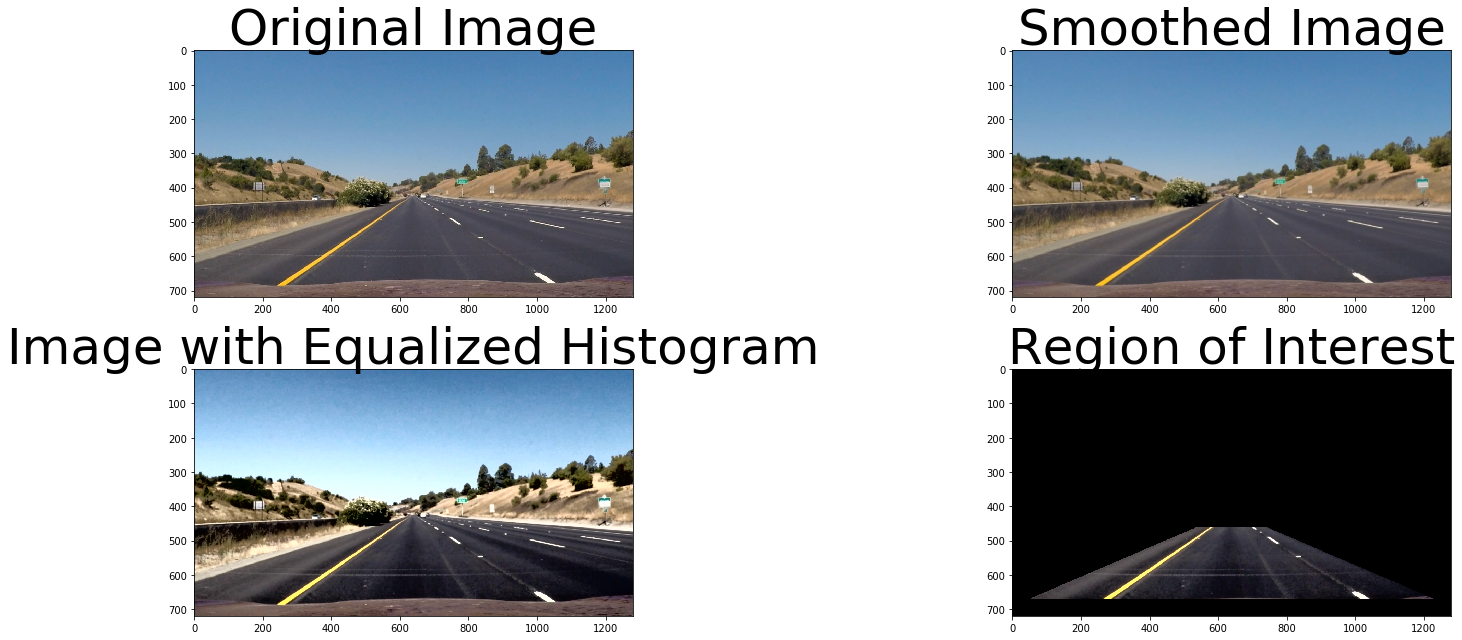

In [475]:
# Preprocessings
smoothed_img = gaussian_blur(lane_sample_img)
hist_equalized_img = equalize_hist(smoothed_img)
roi_img = region_of_interest(hist_equalized_img, calculate_roi_vertices(hist_equalized_img))

# Show binarizing result
show_images([lane_sample_img, smoothed_img, hist_equalized_img, roi_img],
           ['Original Image', 'Smoothed Image', 'Image with Equalized Histogram', 'Region of Interest'],
           2, 2, (24, 9))

### Perspective Transform
Apply a perspective transform to rectify binary image ("birds-eye view").

In [476]:
def unwarp(img, x_offset=200):
    """
    Transperm region of interest to bird eye view. 
    """
    warped = np.copy(img)
    ysize, xsize = img.shape[0], img.shape[1]    
    
    # Set source and destination points
    roi_vertices = calculate_roi_vertices(img)[0]
    src = np.float32([roi_vertices[3], roi_vertices[2], roi_vertices[0], roi_vertices[1]]) 
    dst = np.float32([[x_offset, 0], [xsize - x_offset, 0], [x_offset, ysize], [xsize - x_offset, ysize]])
    
    # Perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR), M

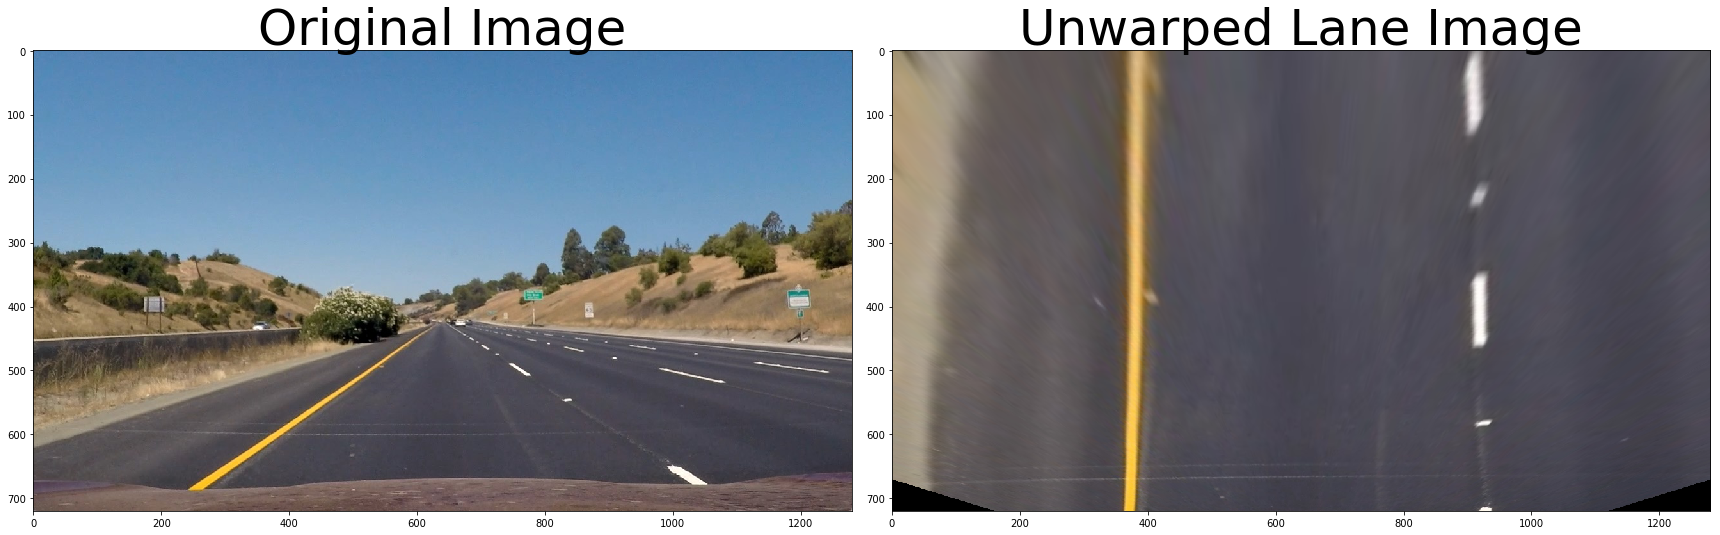

In [477]:
# Undistortion
undist_img, mtx, dist = undistort(lane_sample_img, obj_points, img_points)

# Perspective transform
unwarped_lane_img, M = unwarp(undist_img)

# Show result
show_images([lane_sample_img, unwarped_lane_img],
            ['Original Image', 'Unwarped Lane Image'],
           2, 1, (24, 9))

### Finding Window Centroids

In [478]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width=50, window_height=80, margin=100):
    """
    # Break image into 9 vertical layers since image height is 720
    # How much to slide left and right for searching
    """
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def get_masked_centroids(img, window_centroids, window_width=50, window_height=80):
    """
    Get masked centroids from window centroids.
    """
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
    
    return l_points, r_points


def draw_centroids(img, window_centroids):
    """
    Draw centroids on given image.
    """
    unwarped_img = np.copy(img)
    
    # If we found any window centers
    if len(window_centroids) > 0:
        l_points, r_points = get_masked_centroids(unwarped_img, window_centroids)
        
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((unwarped_img, unwarped_img, unwarped_img))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((unwarped_img,unwarped_img,unwarped_img)),np.uint8)
    
    return output

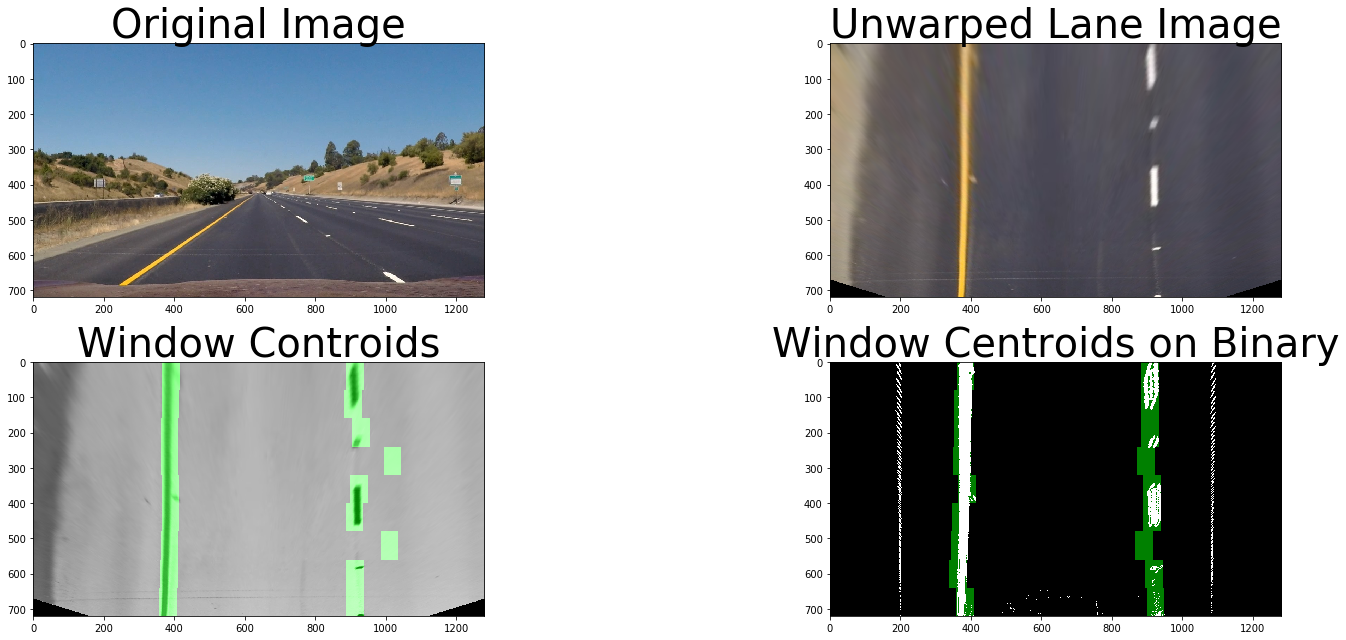

In [479]:
# Find centroids for non binarized image
undist_img, mtx, dist = undistort(lane_sample_img, obj_points, img_points)
unwarped_lane_img, M = unwarp(undist_img)
unwarped_gray_img = cv2.cvtColor(unwarped_lane_img, cv2.COLOR_RGB2GRAY)
window_centroids = find_window_centroids(unwarped_gray_img)
centroid_img = draw_centroids(unwarped_gray_img, window_centroids)

# Find centroids for binarized image
smoothed_img = gaussian_blur(undist_img)
hist_equalized_img = equalize_hist(smoothed_img)
roi_img = region_of_interest(hist_equalized_img, calculate_roi_vertices(hist_equalized_img))
unwarped_lane_img2, M = unwarp(roi_img)
unwarped_lane_img2, threshold_result_img = binarize(unwarped_lane_img2, (20, 100), (42, 80), (170, 255))
window_centroids2 = find_window_centroids(unwarped_lane_img2)
centroid_img2 = draw_centroids(unwarped_lane_img2, window_centroids2)

# Show result
show_images([lane_sample_img, unwarped_lane_img, centroid_img, centroid_img2],
            ['Original Image', 'Unwarped Lane Image', 'Window Controids', 'Window Centroids on Binary'],
           2, 2, (24, 9), 40)

### Find Fitting Line

In [514]:
def find_fitting_line(num_points, l_points, r_points):
    ploty = np.linspace(0, num_points-1, num=num_points)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = np.argmax(l_points, axis=1)
    rightx = np.argmax(r_points, axis=1)
    
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, leftx, rightx, left_fitx, right_fitx


def calculate_curvature(image_size, ploty, leftx, rightx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / image_size[0] # meters per pixel in y dimension
    xm_per_pix = 3.7 / image_size[1] # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

5749.08571849 m 2964.80891774 m


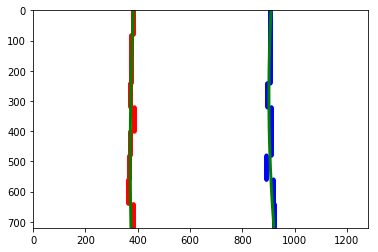

In [515]:
# Get data to find fitting line
l_points, r_points = get_masked_centroids(unwarped_lane_img2, window_centroids2, 1)
ploty, leftx, rightx, left_fitx, right_fitx = find_fitting_line(unwarped_lane_img2.shape[0], l_points, r_points)

# Plot data and fitting line
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, unwarped_lane_img2.shape[1])
plt.ylim(0, unwarped_lane_img2.shape[0])
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Curvature
left_curverad, right_curverad = calculate_curvature(unwarped_lane_img2.shape, ploty, leftx, rightx)
print(left_curverad, 'm', right_curverad, 'm')

### Draw Lane Area & Pipeline

In [518]:
def detect_lanes(img):
    # Preprocessing
    undist_img, mtx, dist = undistort(img, obj_points, img_points)
    smoothed_img = gaussian_blur(undist_img)
    hist_equalized_img = equalize_hist(smoothed_img)
    #roi_img = region_of_interest(hist_equalized_img, calculate_roi_vertices(hist_equalized_img))
    binarized_img, threshold_result_img = binarize(smoothed_img, (20, 100), (42, 80), (170, 255))
    roi_img = region_of_interest(binarized_img, calculate_roi_vertices(binarized_img))

    # Find centroids
    unwarped_lane_img, M = unwarp(roi_img)
    window_centroids = find_window_centroids(unwarped_lane_img)
    #return draw_centroids(unwarped_lane_img, window_centroids)

    # Find fitting line
    l_points, r_points = get_masked_centroids(unwarped_bin_img, window_centroids, 1)
    ploty, leftx, rightx, left_fitx, right_fitx = find_fitting_line(unwarped_bin_img.shape[0], l_points, r_points)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the blank img
    detected_lane_img = np.copy(undist_img) * 0
    #detected_lane_img = np.copy(unwarp(undist_img)[0])
    cv2.fillPoly(detected_lane_img, np.int_([pts]), (0, 255, 0))
    #return detected_lane_img
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    detected_lane_img = cv2.warpPerspective(detected_lane_img, np.linalg.inv(M), (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result_img = cv2.addWeighted(undist_img, 1, detected_lane_img, 0.3, 0)    
    
    
    # Put
    left_curverad, right_curverad = calculate_curvature(result_img.shape, ploty, leftx, rightx)
    
    curv = (left_curverad + right_curverad) / 2.0
    #xm_per_pixel = 3.7 / (RightLine.line_base_pos+LeftLine.line_base_pos)
    #offset=abs(result.shape[1]/2.0 - (RightLine.line_base_pos+LeftLine.line_base_pos)/2.0) * xm_per_pixel    
    curv_text = 'Curvature: ' + str(round(curv, 3)) +' m'
    #offset_text = 'Offset: '+ str(round(offset,2)) +' m'
    font_color = (255,255,255)
    cv2.putText(result_img, curv_text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, font_color, 2, cv2.LINE_AA) 
    #cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, font_color, 2, cv2.LINE_AA)  
    
    return result_img

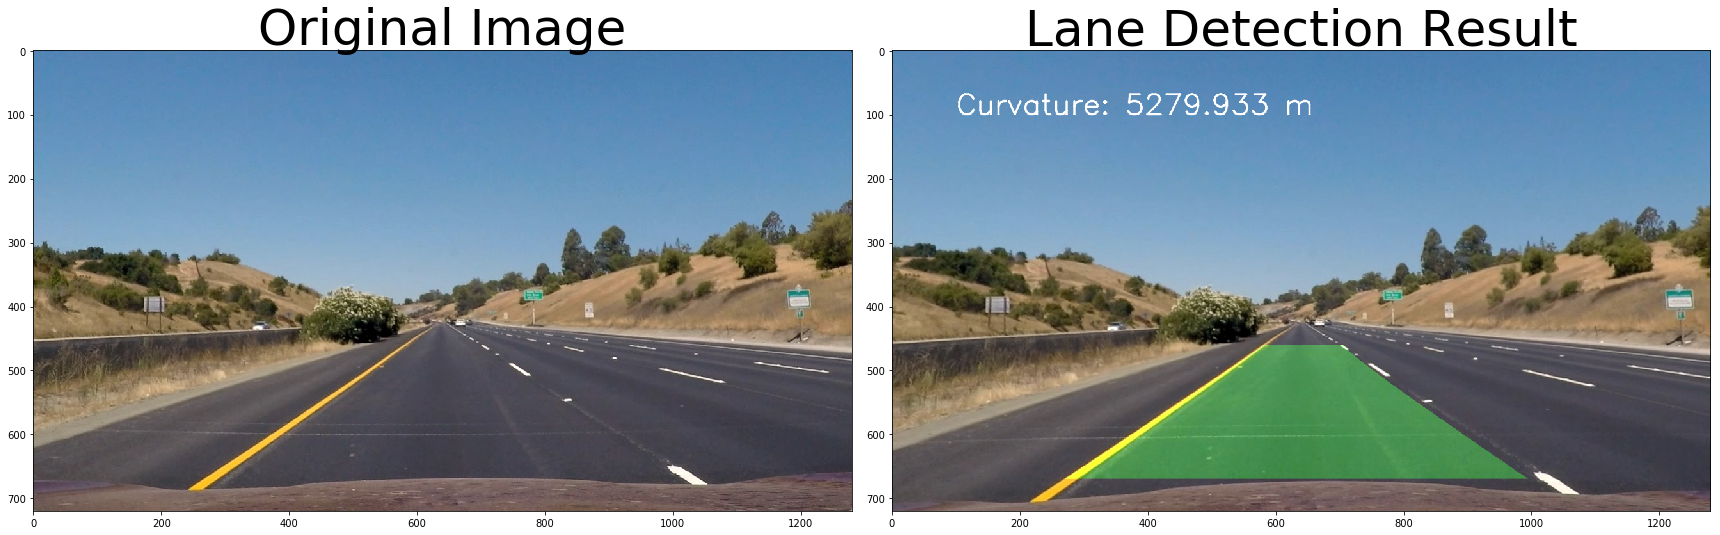

In [519]:
# Run pieline
result_img = detect_lanes(lane_sample_img)

# Show result
show_images([lane_sample_img, result_img],
            ['Original Image', 'Lane Detection Result'],
           2, 1, (24, 9))

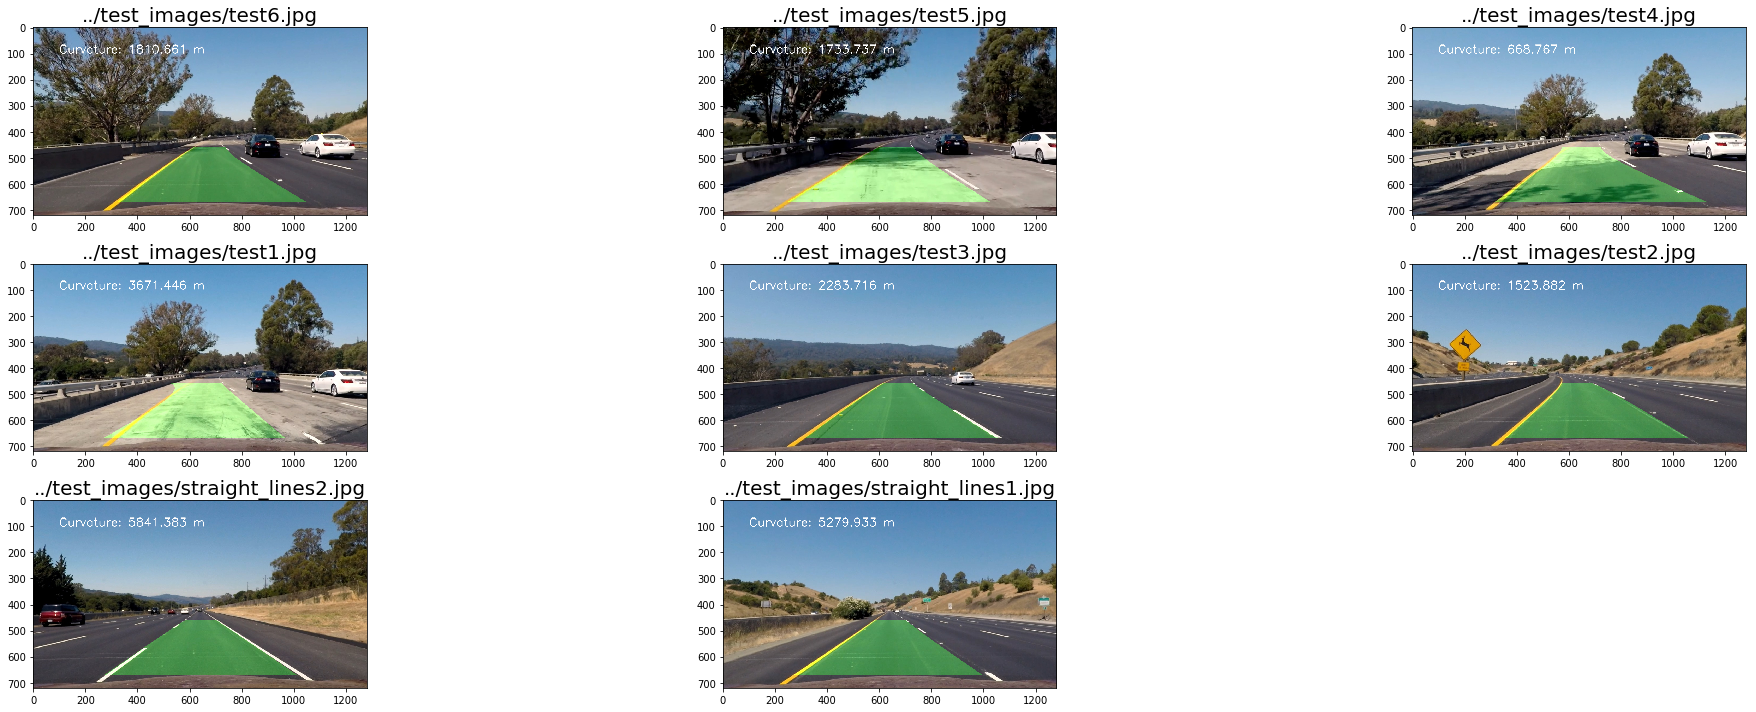

In [520]:
# Load test images
test_lane_image_fnames = glob.glob('../test_images/*.jpg')
result_images = []
result_image_titles = []
for fname in test_lane_image_fnames:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    result_img = detect_lanes(img)
    
    result_images.append(img)
    result_image_titles.append('Original Image')
    result_images.append(result_img)
    result_image_titles.append('Lane Detection Image')

    # Show result
    show_images(result_images,
            result_image_titles,
           2, 1, (24, 9), 30)

## Apply Pipline to Videos

In [485]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [523]:
white_output = 'test_videos_output/project_video_result.mp4'
if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')
    
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(20, 25)
#clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(detect_lanes)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_result.mp4
[MoviePy] Writing video test_videos_output/project_video_result.mp4


100%|█████████▉| 1260/1261 [47:34<00:02,  2.80s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_result.mp4 

CPU times: user 47min 44s, sys: 1min 29s, total: 49min 13s
Wall time: 47min 38s


In [524]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))